<a href="https://colab.research.google.com/github/NirmalMathi/DAT8/blob/master/yolo_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Note: using Google CoLab


In [0]:
import sys
!{sys.executable} -m pip install git+https://github.com/zzh8829/yolov3-tf2.git@master

  Cloning https://github.com/zzh8829/yolov3-tf2.git (to revision master) to /tmp/pip-req-build-o7tzf4b8
  Running command git clone -q https://github.com/zzh8829/yolov3-tf2.git /tmp/pip-req-build-o7tzf4b8
  Created wheel for yolov3-tf2: filename=yolov3_tf2-0.1-cp36-none-any.whl size=8832 sha256=583e5d9970c79ffcf9dba59b871eebfb18a2cab08e9674d0e90c18a7233f2b34
  Stored in directory: /tmp/pip-ephem-wheel-cache-4rnx1rfl/wheels/59/1b/97/905ab51e9c0330efe8c3c518aff17de4ee91100412cd6dd553
Successfully built yolov3-tf2


Before you can make use of YoloV3-TF2 there are several files you must obtain:

#1yolov3.weights - These are the pre-trained weights provided by the author of YOLO.

#2convert.py - This is a Python script that converts yolov3.weights into a TensorFlow compatible weight format.

#3coco.names - The names of the 80 items that the yolov3.weights neural network was trained to recognize.

#4yolov3.tf - The YOLO weights converted to a format that TensorFlow can use directly.

The code provided below obtains these files. The script stores these files to either your GDrive, if you are using CoLab, or a local folder named "data" if you are running locally.

In [0]:
import tensorflow as tf
import os

if COLAB:
  ROOT = '/content/drive/My Drive/Colab Notebooks/yolo'
else:
  ROOT = os.path.join(os.getcwd(),'data')

filename_darknet_weights = tf.keras.utils.get_file(
    os.path.join(ROOT,'yolov3.weights'),
    origin='https://pjreddie.com/media/files/yolov3.weights')
TINY = False

filename_convert_script = tf.keras.utils.get_file(
    os.path.join(os.getcwd(),'convert.py'),
    origin='https://raw.githubusercontent.com/zzh8829/yolov3-tf2/master/convert.py')

filename_classes = tf.keras.utils.get_file(
    os.path.join(ROOT,'coco.names'),
    origin='https://raw.githubusercontent.com/zzh8829/yolov3-tf2/master/data/coco.names')
filename_converted_weights = os.path.join(ROOT,'yolov3.tf')

8192/1277 [================================================================================================================================================================================================] - 0s 0us/step


#transfering weights
The weights provided by the original authors of YOLO is not directly compatible with TensorFlow. Because of this, it is necessary first to convert the YOLO provided weights into a TensorFlow compatible format. The following code does this conversion. This process does not need to be repeated by the program. Once the conversion script processes YOLO weights the saved to the yolov3.tf YOLO can reuse these converted wights. The following code performs this conversion.

In [0]:
import sys
!{sys.executable} "{filename_convert_script}" --weights "{filename_darknet_weights}" --output "{filename_converted_weights}"

2020-05-02 13:22:44.723029: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-05-02 13:22:46.482254: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-02 13:22:46.484021: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-05-02 13:22:46.484058: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (00c2f68308cd): /proc/driver/nvidia/version does not exist
2020-05-02 13:22:46.511277: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2020-05-02 13:22:46.511493: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1bb4bc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-05-02 13:22:46.511552: I tensorflow/com

#The conversion script is no longer needed once this script converts the YOLO weights have to a TensorFlow format. Because this executable file resides in the same directory as the course files, we delete it at this point.
#

In [0]:
import os
os.remove(filename_convert_script)

Now that we have all of the files needed for YOLO, we are ready to use it to recognize components of an image.

# Running DarkFlow (YOLO)

##The YoloV3-TF2 library can easily integrate with Python applications. The initialization of the library consists of three steps.

#1First, it is essential to import all of the needed packages for the library

#2he Python program must define all of the YOLO configurations through the Keras flags architecture.

#3 Finally, we must scan available devices so that our application takes advantage of any GPUs. The following code performs all three of these steps.

In [0]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (YoloV3, YoloV3Tiny)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
import sys
from PIL import Image, ImageFile
import requests

In [0]:


# Flags are used to define several options for YOLO.
flags.DEFINE_string('classes', filename_classes, 'path to classes file')
flags.DEFINE_string('weights', filename_converted_weights, 'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
FLAGS([sys.argv[0]])

# Locate devices to run YOLO on (e.g. GPU)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#It is important to understand that Keras flags can only be defined once. If you are going to classify more than one image, make sure that you do not define the flags additional times.

The following code initializes a YoloV3-TF2 classification object. The weights are loaded, and the object is ready for use as the yolo variable. It is not necessary to reload the weights and obtain a new yolo variable for each classification.

In [0]:
# This example does not use the "Tiny version"
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

# Load weights and classes
yolo.load_weights(FLAGS.weights).expect_partial()
print('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print('classes loaded')

weights loaded
classes loaded


In [0]:
#Read image to classify
url = "https://raw.githubusercontent.com/smilyamit/Google_Colab/master/bird.jpg"
response = requests.get(url)
img_raw = tf.image.decode_image(response.content, channels=3)

#At this point, we can classify the image that was just loaded. The program should preprocess the image so that it is the size expected by YoloV3-TF2. Your program also sets the confidence threshold at this point. Any sub-image recognized with confidence below this value is not returned by YOLO.

In [0]:
# Preprocess image
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

# Desired threshold (any sub-image below this confidence level will be ignored.)
FLAGS.yolo_score_threshold = 0.5

# Recognize and report results
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print(f"Prediction time: {hms_string(t2 - t1)}")

Prediction time: 0:00:01.42


#It is important to note that the yolo class instantiated here is a callable object, which means that it can fill the role of both an object and a function. Acting as a function, yolo returns three arrays named boxes, scores, and classes that are of the same length. The function returns all sub-images found with a score above the minimum threshold. Additionally, the yolo function returns an array named called nums. The first element of the nums array specifies how many sub-images YOLO found to be above the score threshold.

#boxes - The bounding boxes for each of the sub-images detected in the image sent to YOLO.
#scores - The confidence for each of the sub-images detected.
#classes - The string class names for each of the items. These are COCO names such as "person" or "dog."
#nums - The number of images above the threshold.

Your program should use these values to perform whatever actions you wish as a result of the input image. The following code simply displays the images detected above the threshold.

In [0]:
print('detections:')
for i in range(nums[0]):
    cls = class_names[int(classes[0][i])]
    score = np.array(scores[0][i])
    box = np.array(boxes[0][i])
    print(f"\t{cls}, {score}, {box}")

detections:
	bird, 0.9989942312240601, [0.6705626  0.22237915 0.83068657 0.5081108 ]
	bird, 0.983874499797821, [0.22646993 0.30853966 0.41653323 0.6679983 ]
	bird, 0.9647555351257324, [0.3787675  0.33430362 0.65111125 0.6458536 ]
	bird, 0.9113000631332397, [0.4350178  0.24012072 0.68641746 0.4485944 ]
	bird, 0.811153769493103, [0.83861697 0.2265045  0.9054198  0.49907786]
	bird, 0.7983991503715515, [0.00660969 0.21553881 0.10245529 0.49492723]
	bird, 0.6133720278739929, [0.11819684 0.3217946  0.28392613 0.57493746]
	bird, 0.5825008749961853, [0.25929618 0.16043752 0.40140265 0.35462666]


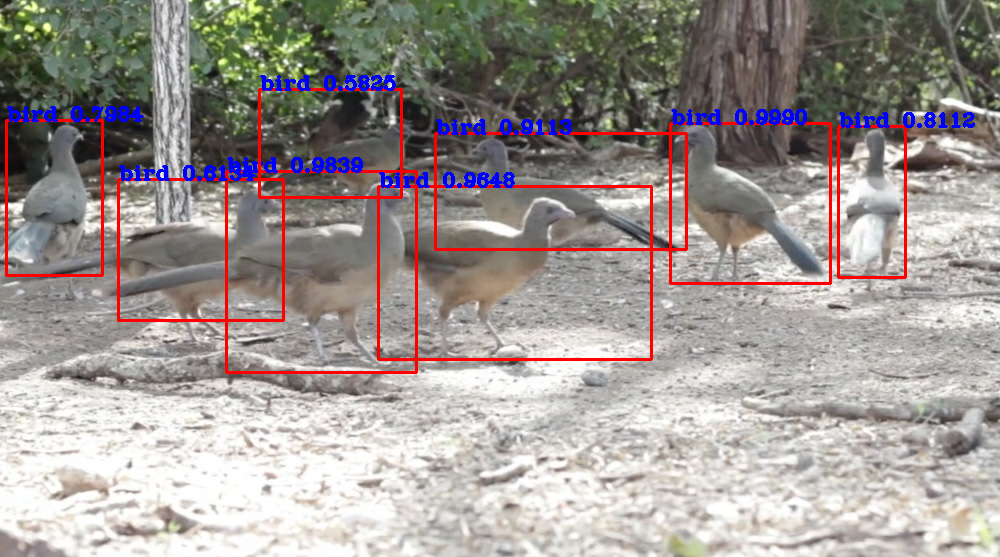

In [0]:
# Display image using YOLO library's built in function
img = img_raw.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image

In [0]:
# 2nd image
url = "https://raw.githubusercontent.com/smilyamit/Google_Colab/master/Amit_prague.jpg"
response = requests.get(url)
img_raw1 = tf.image.decode_image(response.content, channels=3)

In [0]:
# Preprocess image
img = tf.expand_dims(img_raw1, 0)
img = transform_images(img, FLAGS.size)

# Desired threshold (any sub-image below this confidence level will be ignored.)
FLAGS.yolo_score_threshold = 0.5

# Recognize and report results
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print(f"Prediction time: {hms_string(t2 - t1)}")

Prediction time: 0:00:01.46


In [0]:
# Display image using YOLO library's built in function
img = img_raw1.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image